In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from zipfile import ZipFile
import os
from shutil import copyfile
import shutil
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ToTensor, Normalize, Resize, Compose, ColorJitter
from torchvision.utils import make_grid

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Check for GPU availability
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Set up the data folder
data_folder = os.path.join(os.curdir, 'AllData')

# Unzip the data file
data_zipped_path = os.path.join(data_folder, 'archive.zip')
dataset_path = os.path.join(data_folder, 'dataset')
with ZipFile(data_zipped_path, 'r') as zip_ref:
    if os.path.exists(dataset_path):
        print('Data already extracted')
    else:
        zip_ref.extractall(data_folder)
        print('Data extracted')

Data already extracted


In [4]:
# Load the data labels
class_names = sorted(os.listdir(dataset_path))
n_classes = len(class_names)
print('Number of classes: {}'.format(n_classes))

class_dis = [len(os.listdir(dataset_path + "/" + name)) for name in class_names]
print('Number of images in each class: {}'.format(class_dis))

Number of classes: 11
Number of images in each class: [698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]


In [5]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

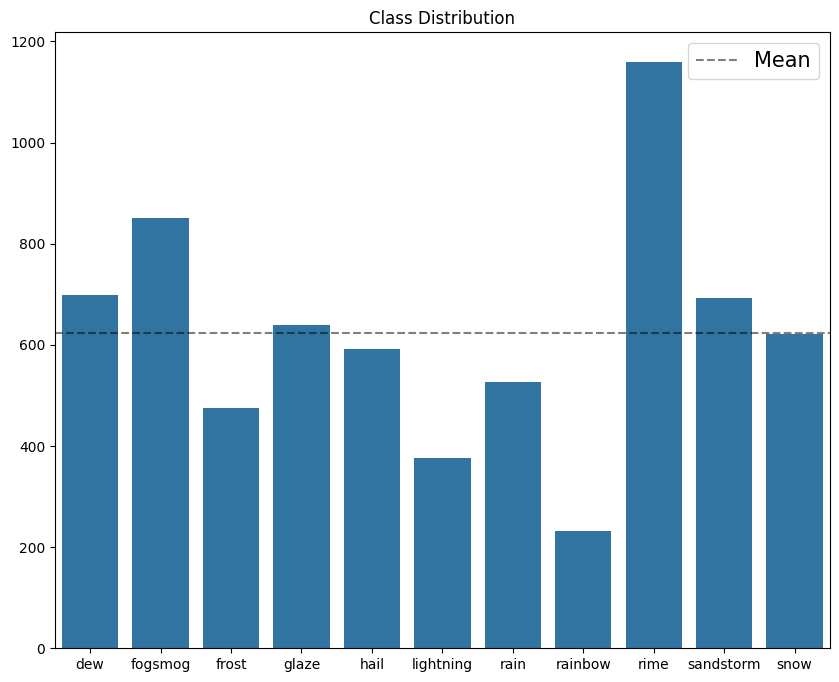

In [6]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

In [7]:
# Define the paths for your dataset
train_path = os.path.join(data_folder, 'train')
val_path = os.path.join(data_folder, 'val')
test_path = os.path.join(data_folder, 'test')

In [8]:
# Create the train, val, and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [9]:
# List all class directories in the dataset directory
class_dirs = os.listdir(dataset_path)
print(class_dirs)

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [10]:
# Split each class into train, val, and test
for class_dir in class_dirs:
    class_path = os.path.join(dataset_path, class_dir)
    
    # Create class directories in train, val, and test
    os.makedirs(os.path.join(train_path, class_dir), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_dir), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_dir), exist_ok=True)
    
    # List all image files in the class directory
    image_files = os.listdir(class_path)
    
    # Split the image files into train, val, and test
    train_files, temp_files = train_test_split(image_files, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    
    # Copy images to the respective directories
    for filename in train_files:
        src = os.path.join(class_path, filename)
        dst = os.path.join(os.path.join(train_path, class_dir), filename)
        shutil.copy(src, dst)
    
    for filename in val_files:
        src = os.path.join(class_path, filename)
        dst = os.path.join(os.path.join(val_path, class_dir), filename)
        shutil.copy(src, dst)
    
    for filename in test_files:
        src = os.path.join(class_path, filename)
        dst = os.path.join(os.path.join(test_path, class_dir), filename)
        shutil.copy(src, dst)

print("Dataset split into train, val, and test sets.")

Dataset split into train, val, and test sets.


In [11]:
# Load the data using pytorch with their class labels
data = ImageFolder(dataset_path, transform=ToTensor())
print('Number of images: {}'.format(len(data)))

Number of images: 6862


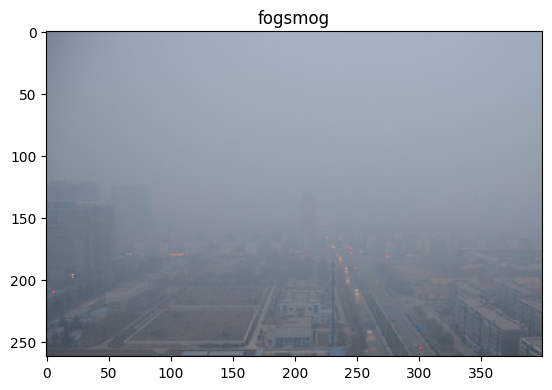

In [12]:
# Data visualization
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.show()

# Show a random image
idx = np.random.randint(len(data))
img, label = data[idx]
show_image(img, class_names[label])

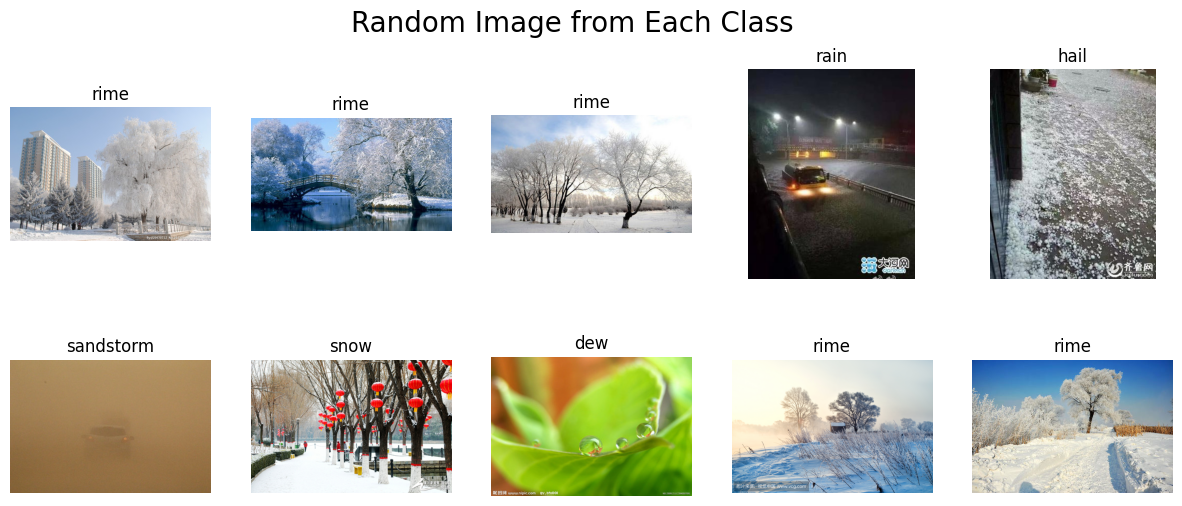

In [13]:
# Show a random image from each class
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Random Image from Each Class", fontsize=20)

for i in range(2):
    for j in range(5):
        idx = np.random.randint(len(data))
        img, label = data[idx]
        ax[i, j].imshow(img.permute(1, 2, 0))
        ax[i, j].set_title(class_names[label])
        ax[i, j].axis('off')
plt.show()

# Preprocess the data


In [14]:
# Reshape the images to 224 x 224
train_data = ImageFolder(train_path, transform=Compose([Resize((224, 224)), ToTensor()]))
val_data = ImageFolder(val_path, transform=Compose([Resize((224, 224)), ToTensor()]))
test_data = ImageFolder(test_path, transform=Compose([Resize((224, 224)), ToTensor()]))


print('Number of training images: {}'.format(len(train_data)))
print('Number of validation images: {}'.format(len(val_data)))
print('Number of testing images: {}'.format(len(test_data)))

Number of training images: 4113
Number of validation images: 1371
Number of testing images: 1378


In [15]:
# Data augmentation
train_transform = Compose([
    RandomHorizontalFlip(),
    transforms.Resize((300, 400)),
    RandomRotation(10),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

val_transform = Compose([
    transforms.Resize((300, 400)),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

test_transform = Compose([
    transforms.Resize((300, 400)),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

train_data = ImageFolder(train_path, transform=train_transform)
val_data = ImageFolder(val_path, transform=val_transform)
test_data = ImageFolder(test_path, transform=test_transform)

print('Number of training images after augmentation: {}'.format(len(train_data)))
print('Number of validation images after augmentation: {}'.format(len(val_data)))
print('Number of testing images after augmentation: {}'.format(len(test_data)))

Number of training images after augmentation: 4113
Number of validation images after augmentation: 1371
Number of testing images after augmentation: 1378


In [16]:
# Data loaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


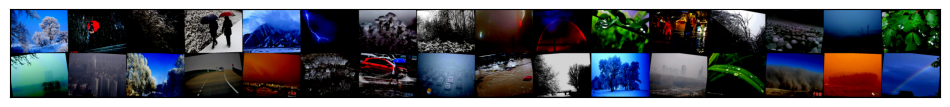

In [17]:
# Data visualization
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

In [18]:
# Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=64*37*50, out_features=128)  # Adjust the input size here
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [19]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 20  # Increase the number of epochs

# Initialize the model and optimizer
model = CNN(num_classes=n_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

In [20]:
# Cross-validation
n_splits = 5  # Number of cross-validation folds
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
fold = 0

val_accuracies = []
test_accuracies = []

In [21]:
for train_index, val_index in kf.split(range(len(train_data)), [label for (_, label) in train_data]):
    fold += 1
    print(f"Fold {fold}/{n_splits}")

    # Split the data into train and validation sets for this fold
    train_fold, val_fold = random_split(
        train_data, [len(train_index), len(val_index)], generator=torch.Generator().manual_seed(seed)
    )

    # Create data loaders for this fold
    train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_fold, batch_size=batch_size, shuffle=True)

    best_val_accuracy = 0.0
    early_stopping_patience = 5
    early_stopping_counter = 0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()  # Update learning rate at the end of each epoch

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val * 100
        print(f'Fold {fold}, Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%')

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stopping_counter = 0
            best_model_weights = model.state_dict()
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    # Load the best model weights
    model.load_state_dict(best_model_weights)

    # Evaluate on the test set for this fold
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test * 100
    print(f'Fold {fold}, Test Accuracy: {test_accuracy:.2f}%')

    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

# Calculate and print average validation and test accuracies over all folds
avg_val_accuracy = sum(val_accuracies) / n_splits
avg_test_accuracy = sum(test_accuracies) / n_splits

print(f'Average Validation Accuracy: {avg_val_accuracy:.2f}%')
print(f'Average Test Accuracy: {avg_test_accuracy:.2f}%')

Fold 1/5
Fold 1, Epoch 1/20, Validation Accuracy: 47.51%
Fold 1, Epoch 2/20, Validation Accuracy: 55.65%
Fold 1, Epoch 3/20, Validation Accuracy: 59.54%
Fold 1, Epoch 4/20, Validation Accuracy: 58.93%
Fold 1, Epoch 5/20, Validation Accuracy: 58.69%
Fold 1, Epoch 6/20, Validation Accuracy: 61.24%
Fold 1, Epoch 7/20, Validation Accuracy: 64.76%
Fold 1, Epoch 8/20, Validation Accuracy: 66.10%
Fold 1, Epoch 9/20, Validation Accuracy: 64.64%
Fold 1, Epoch 10/20, Validation Accuracy: 62.21%
Fold 1, Epoch 11/20, Validation Accuracy: 66.10%
Fold 1, Epoch 12/20, Validation Accuracy: 64.28%
Fold 1, Epoch 13/20, Validation Accuracy: 66.95%
Fold 1, Epoch 14/20, Validation Accuracy: 64.64%
Fold 1, Epoch 15/20, Validation Accuracy: 67.07%
Fold 1, Epoch 16/20, Validation Accuracy: 66.22%
Fold 1, Epoch 17/20, Validation Accuracy: 67.44%
Fold 1, Epoch 18/20, Validation Accuracy: 67.80%
Fold 1, Epoch 19/20, Validation Accuracy: 68.41%
Fold 1, Epoch 20/20, Validation Accuracy: 65.98%
Fold 1, Test Accurac

##### Average Validation Accuracy: 67.49%
##### Average Test Accuracy: 73.02%

In [22]:
# Save the model
torch.save(model.state_dict(), os.path.join(os.curdir, 'model.pt'))